# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [224]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os

## Generating the data

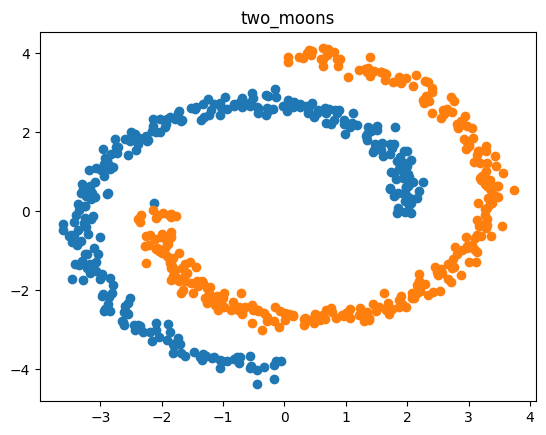

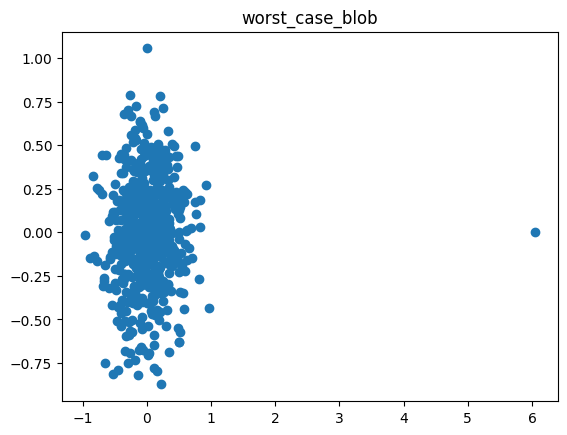

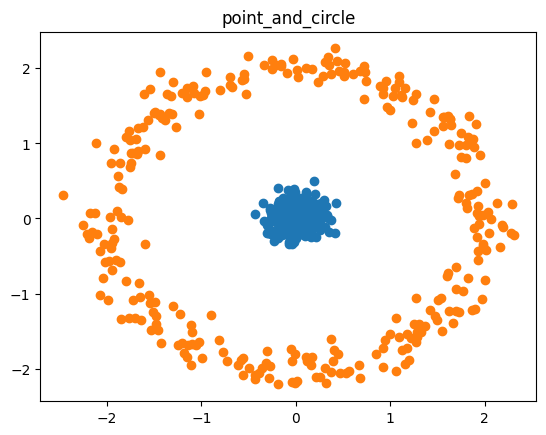

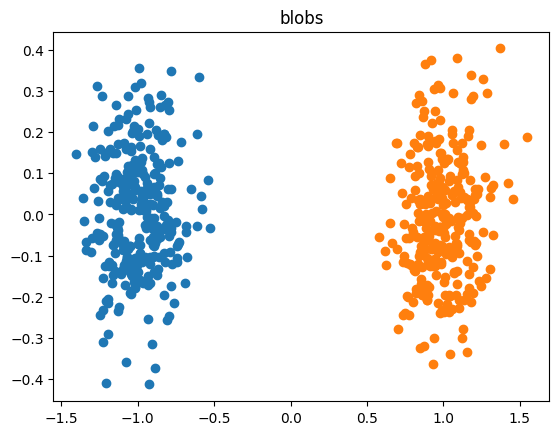

In [225]:
# Example

for fn in [two_moons, worst_case_blob, point_and_circle, blobs]:  #  try also [worst_case_blob, point_and_circle, blobs]
#for fn in [two_moons]:  
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    plt.title(str(fn.__name__))
    plt.show()
    
# You can check the documentation of each function to see the optional parameters, e.g.:

## Building similarity graph

In [226]:
from sklearn.metrics import pairwise_distances

def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
    similarities = np.exp(-pairwise_distances(X,metric='euclidean')**2/(2*var))

    

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        similarities[similarities < eps] = 0
        W = similarities
        
        
        

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        for i in range(n):
            knn = np.argsort(similarities[i])[::-1][:k]
            W[i, knn] = similarities[i, knn]
        W = np.maximum(W, W.T)

            
        
            
    return W


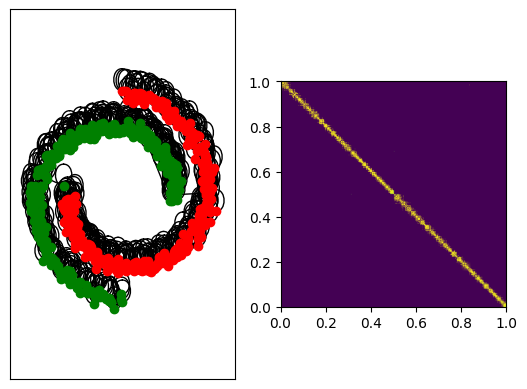

In [228]:
# Example
X,Y = two_moons(num_samples=600)
W = build_similarity_graph(X, k=10)
W[0, 599] = 1    # add two placeholder edges to reproduce example picture
W[10, 500] = 1   # 


plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

## Computing the Laplacian

In [229]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    L = np.zeros(W.shape)
    n = W.shape[0]

    d = np.sum(W, axis=1)  
    D = np.diag(d)

    if laplacian_normalization == 'unn':
        L = D - W
    elif laplacian_normalization == "sym":
        d = W.sum(axis=1)
        d_inv_sqrt = np.zeros(n)
        idx = d > 0
        d_inv_sqrt[idx] = 1.0 / np.sqrt(d[idx])
        D_inv_sqrt = np.diag(d_inv_sqrt)

        L = np.eye(n) - D_inv_sqrt @ W @ D_inv_sqrt


    elif laplacian_normalization == 'rw':
        inv_D = np.linalg.inv(D)
        L = np.eye(n) - inv_D @ W

    else:
        raise ValueError("Invalid laplacian_normalization value. Choose from 'unn', 'sym', 'rw'.")
    
    # for example (unnormalized): L = D - W
    return L

## Clustering

In [ ]:
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    E, U = scipy.linalg.eig(L)
    idx = np.argsort(E.real)

    U = U[:, idx].real
    E = E[idx].real

    if chosen_eig_indices is None:
        max_eigs = min(30, len(E))
        small_E = E[:max_eigs]
        gaps = small_E[1:] - small_E[:-1]
        gap_threshold = 3*np.median(gaps)
        last_idx = 0
        for i, gap in enumerate(gaps):
            if gap > gap_threshold:
                last_idx = i + 1
        chosen_eig_indices = list(range(last_idx + 1))

    X_spec = U[:, chosen_eig_indices]

    kmeans = KMeans(n_clusters=num_classes, n_init="auto")
    Y = kmeans.fit_predict(X_spec)

    return Y



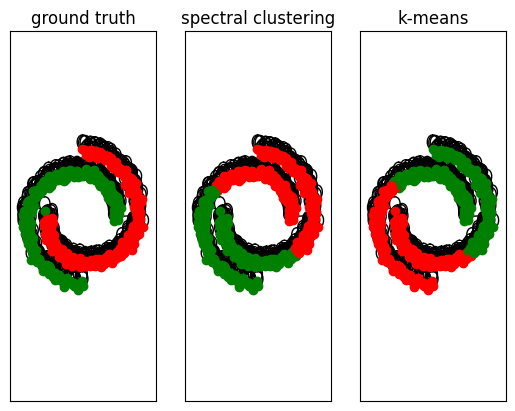

In [235]:
# Example

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1, 2], num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

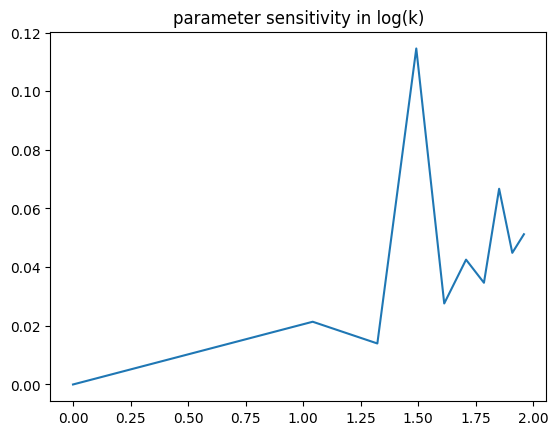

In [239]:
def parameter_sensitivity(param_type="k"):
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 1.0  # exponential_euclidean's sigma^2
    laplacian_normalization = 'unn'
    chosen_eig_indices = None

    """
    Choose candidate parameters
    """
    parameter_type = param_type 

    if parameter_type == 'eps':
        parameter_candidate = np.linspace(0.1, 1.0, 30)  
    elif parameter_type == 'k':
        parameter_candidate = list(range(1,100,10))
    else:
        raise ValueError("Invalid parameter_type value. Choose from 'k' or 'eps'.")
    parameter_performance = []

    for parameter in parameter_candidate:
        # Generate data
        X, Y = two_moons(num_samples, 1, 0.02)
        num_classes = len(np.unique(Y))
        
        parameter_wrap = {parameter_type: parameter}
        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, laplacian_normalization)

        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

    plt.figure()
    plt.plot(np.log(parameter_candidate)/np.log(10), parameter_performance)
    plt.title(f'parameter sensitivity in log({parameter_type})')
    plt.show()

parameter_sensitivity()

## Image segmentation

In [240]:
def image_segmentation(input_img='four_elements.bmp',n_class = 4, eps=0.5, var=1, k=5,chosen_eig_indices=None, ln="rw"):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """

    W = build_similarity_graph(Xr, var=var, k=k, eps=eps)
    L = build_laplacian(W, ln)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=n_class)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

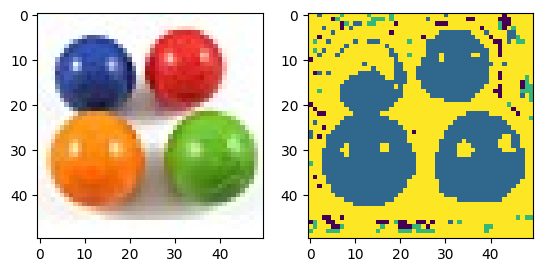

In [241]:
image_segmentation()

# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

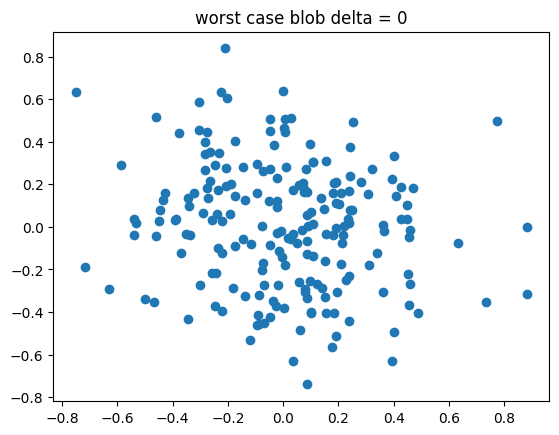

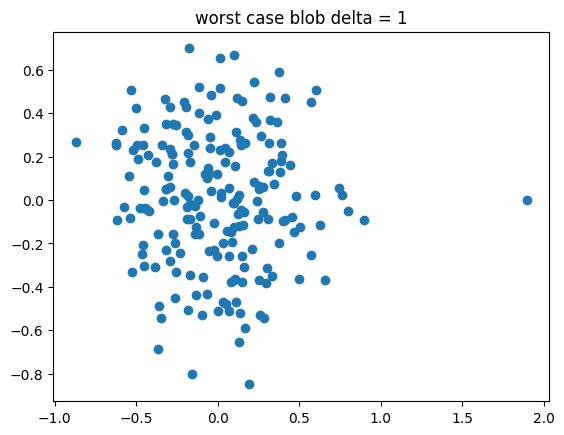

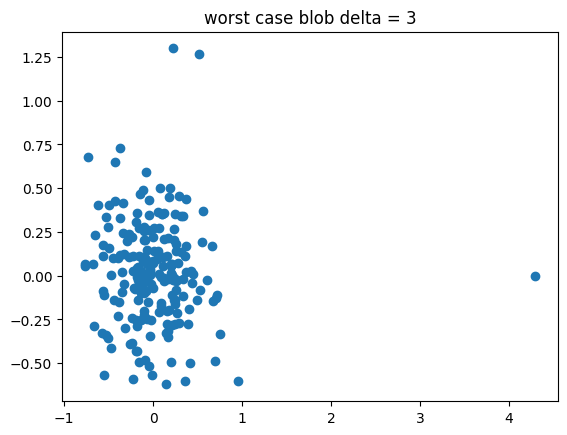

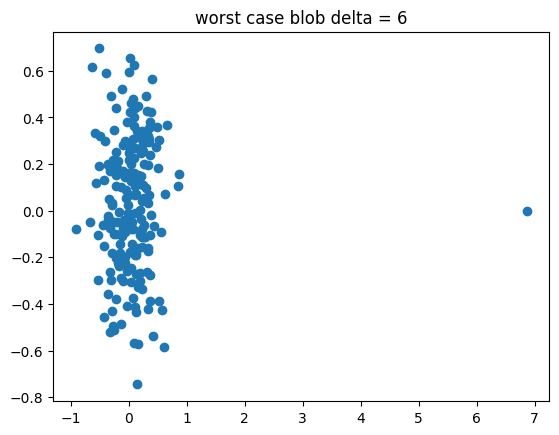

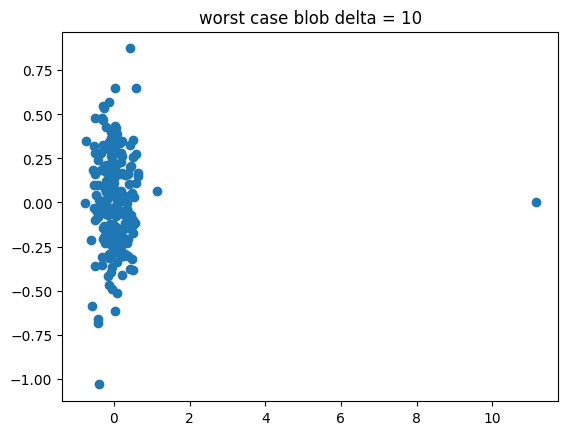

In [80]:
deltas = [0, 1, 3, 6, 10]
num_samples = 200
for d in deltas:
    X,Y = worst_case_blob(num_samples=num_samples, delta=d)
    plot_clusters(X,Y, fignum=str(d))
    plt.title(f"worst case blob delta = {d}")
    plt.show()


In the function `worst_case_blob`, the parameter `delta` controls the position of a single outlier point relative to the main Gaussian blob.

After generating a Gaussian blob centered at (0, 0), the last sample is manually displaced using:

    X[-1] = [max(X) + delta, 0]

Therefore increasing `delta` increases the separation between the outlier and the main cluster and reducing it reduces the separation between the outlier and the main cluster.

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

Delta = 0.10
  ε          : 0.9376


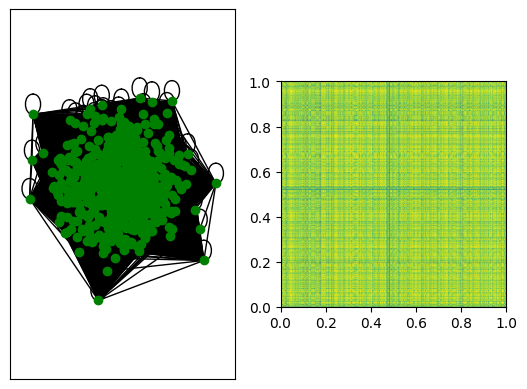

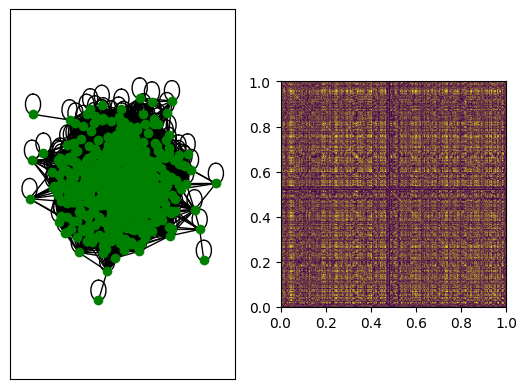

Delta = 0.76
  ε          : 0.6879


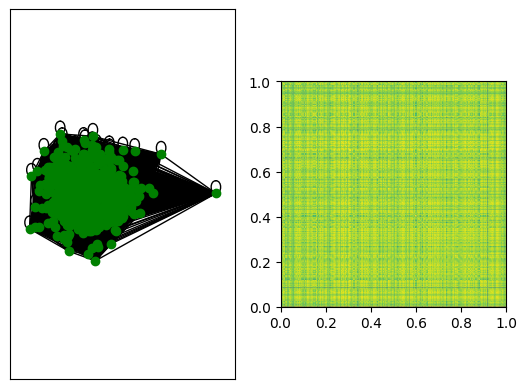

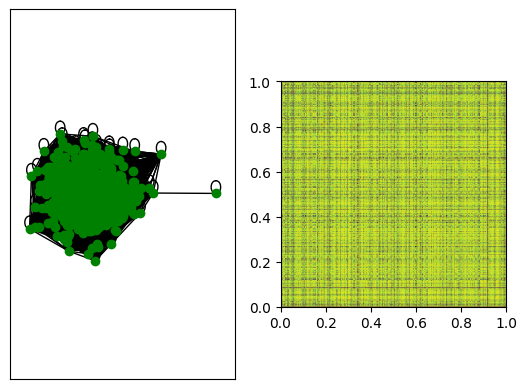

Delta = 1.41
  ε          : 0.2396


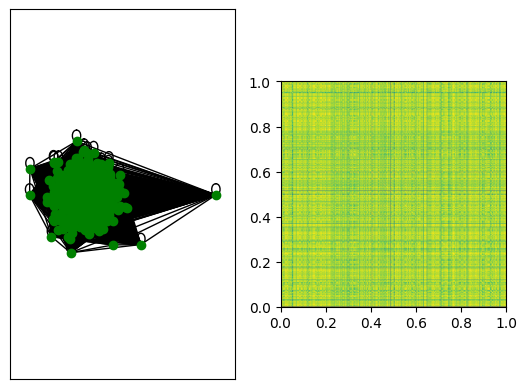

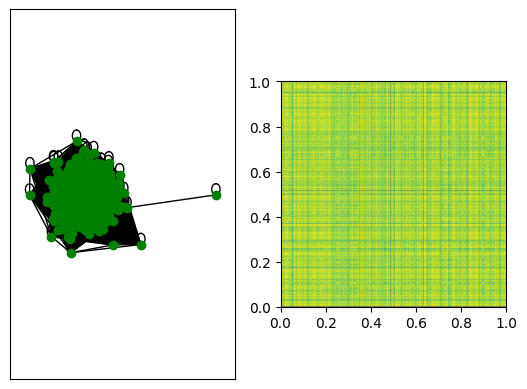

Delta = 2.07
  ε          : 0.1125


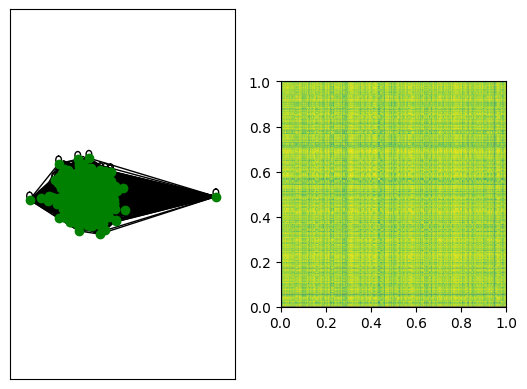

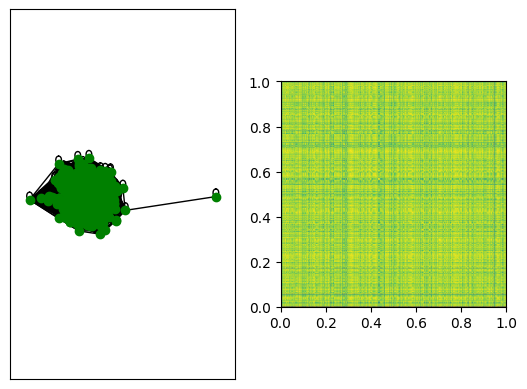

Delta = 2.72
  ε          : 0.0230


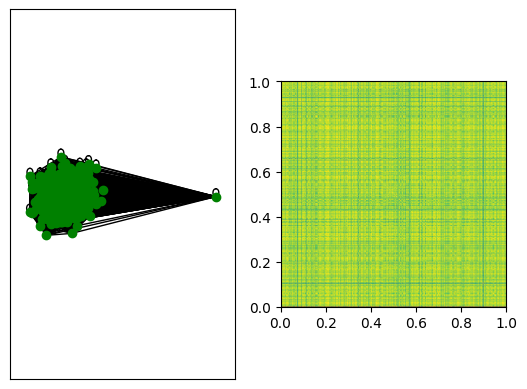

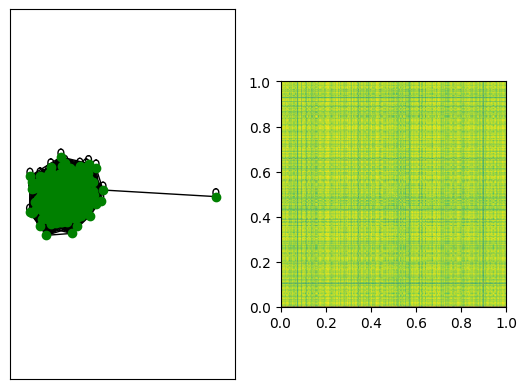

Delta = 3.38
  ε          : 0.0033


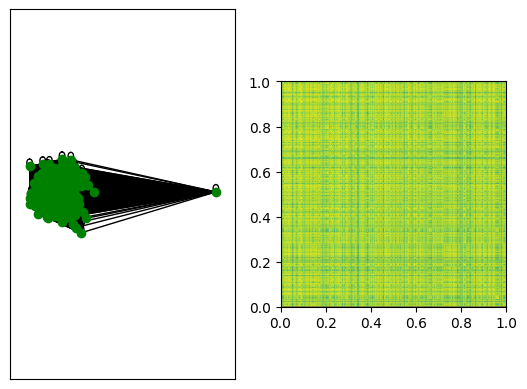

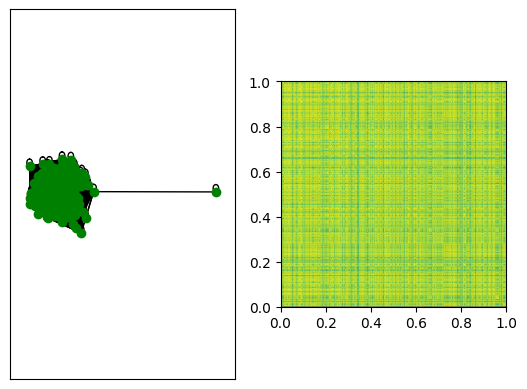

Delta = 4.03
  ε          : 0.0002


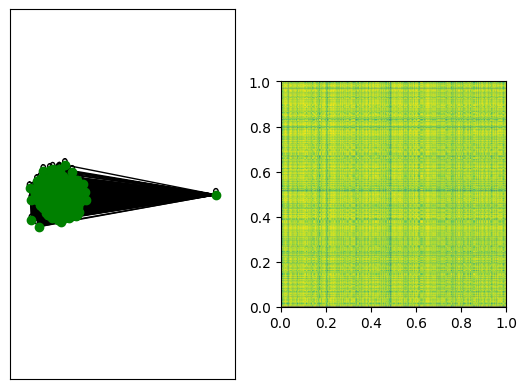

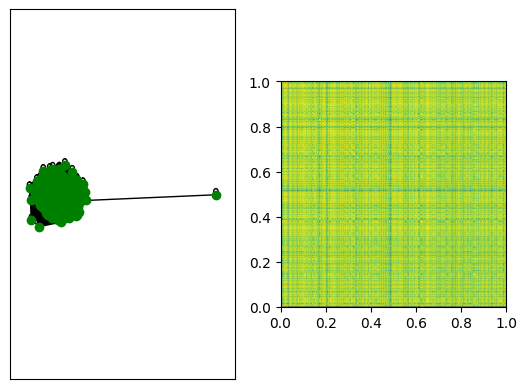

Delta = 4.69
  ε          : 0.0000


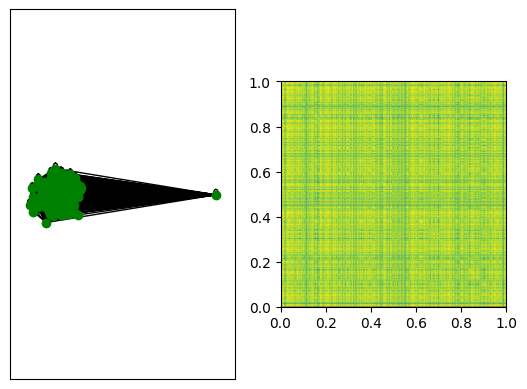

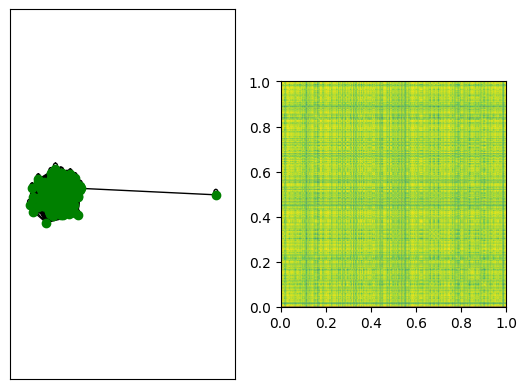

Delta = 5.34
  ε          : 0.0000


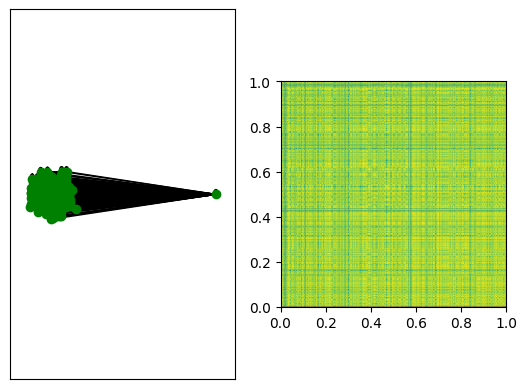

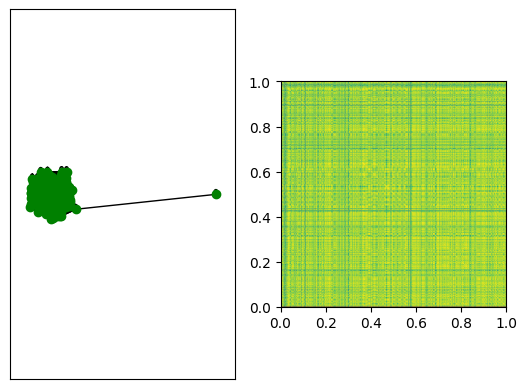

Delta = 6.00
  ε          : 0.0000


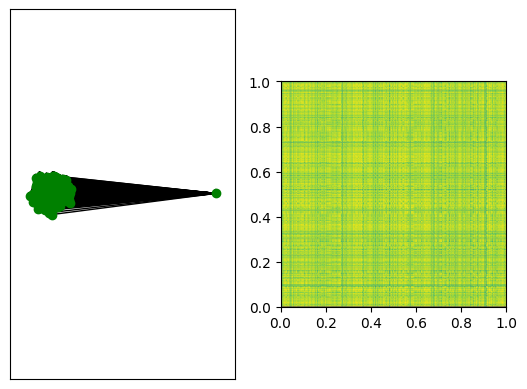

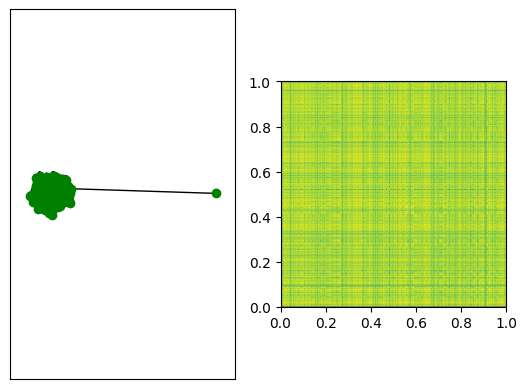

In [242]:
edge_reduction_ratios = []
epsilon_values = []

delta_values = np.linspace(0.1, 6, 10)
num_samples = 600
var = 1.0

for delta in delta_values:
    X, Y = worst_case_blob(num_samples=num_samples, delta=delta)
    W_full = build_similarity_graph(X, var=var, eps=0)
    tree = min_span_tree(-W_full)
    mst_weights = tree * W_full
    eps = np.min(mst_weights[mst_weights > 0])

    W_eps = build_similarity_graph(X, var=var, eps=eps)

    num_edges_full = np.count_nonzero(W_full) // 2
    num_edges_eps = np.count_nonzero(W_eps) // 2
    reduction_ratio = 100 * (num_edges_full - num_edges_eps) / num_edges_full


    print("=" * 50)
    print(f"Delta = {delta:.2f}")
    print(f"  ε          : {eps:.4f}")
    print("=" * 50)

    plot_graph_matrix(X, Y, W_full, f"Full graph (δ={delta:.2f})")
    plot_graph_matrix(X, Y, W_eps,  f"Epsilon graph (δ={delta:.2f})")


    edge_reduction_ratios.append(reduction_ratio)
    epsilon_values.append(eps)


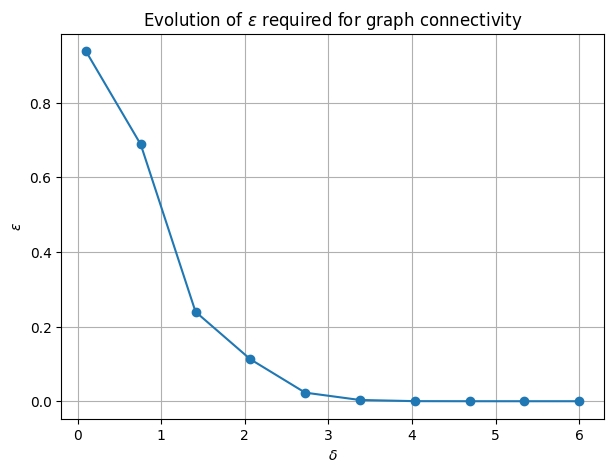

In [243]:
plt.figure(figsize=(7, 5))
plt.plot(delta_values, epsilon_values, marker='o')
plt.xlabel(r'$\delta$')
plt.ylabel(r'$\varepsilon$')
plt.title(r'Evolution of $\varepsilon$ required for graph connectivity')
plt.grid(True)
plt.show()

As we can see on the figures, when $\delta$ increases, $\epsilon$ quickly goes to $0$.

This is because the outlier is moved farther away from the main cluster, which makes its similarity with the other points extremely small.To keep the graph connected, $\epsilon$ must be at most equal to this very small similarity.
As a result, the $\epsilon$ graph becomes almost fully connected and loses its sparsity.  
This shows that choosing $\epsilon$ only to ensure connectivity is a bad idea, especially when outliers are present, since it leads to inefficient and poorly structured graphs.
In conclusion, this method is a bad idea with large deltas because the graph will be overconnected and will give no information.


### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

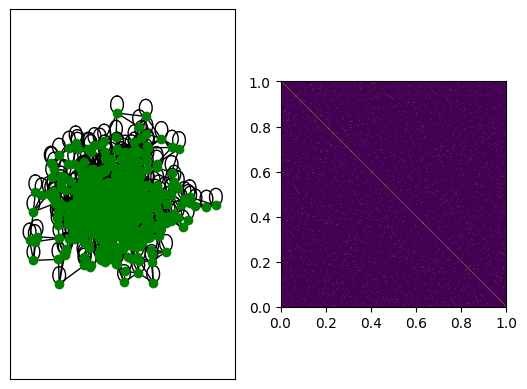

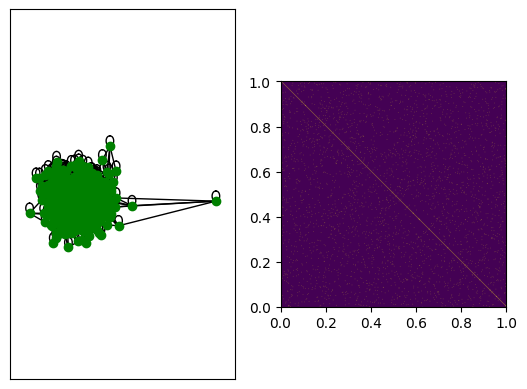

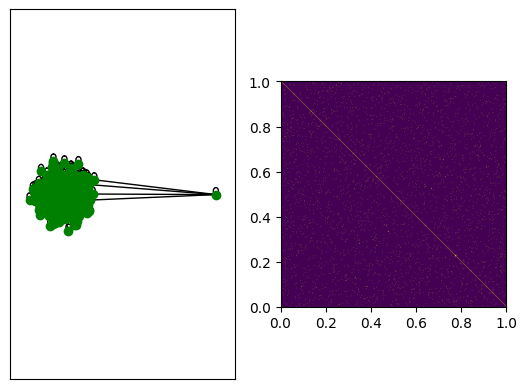

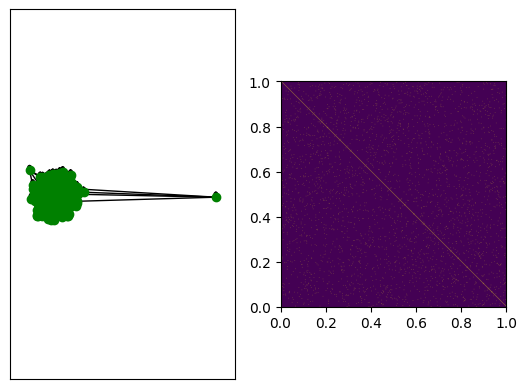

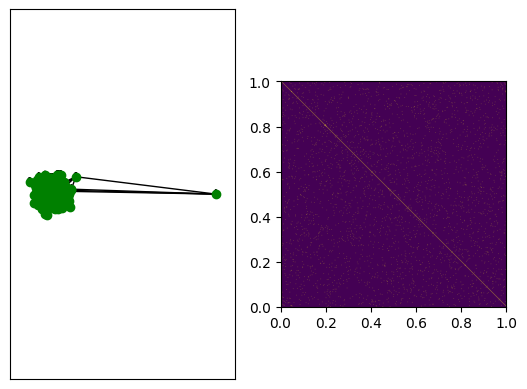

In [96]:
delta_values = np.linspace(0.1, 6, 5)
num_samples = 600


for delta in delta_values:
    X, Y = worst_case_blob(num_samples=num_samples, delta = delta)
    W = build_similarity_graph(X, k = 5)
    plot_graph_matrix(X, Y, W)


Yes, building a connected graph is important for spectral clustering, since connectivity ensures that information can propagate across all points and that the Laplacian spectrum is meaningful.

- With k-NN graphs, connectivity is not guaranteed: isolated points or outliers may not be connected to the main component if k is too small, making the choice of k difficult.

- With $\epsilon$ graphs, connectivity is easier to enforce by decreasing $\epsilon$ , but choosing $\epsilon$  is delicate:.


### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

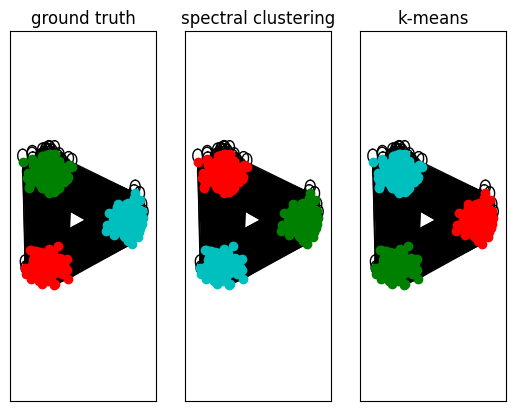

In [ ]:
num_samples = 600
n_blobs = 3
k = 3

X, Y = blobs(num_samples=num_samples,n_blobs=n_blobs)

W = build_similarity_graph(X, eps=0,)
laplacian = build_laplacian(W, laplacian_normalization='rw')
chosen_eig_indices = list(range(0, n_blobs))

Y_rec = spectral_clustering(laplacian, chosen_eig_indices=chosen_eig_indices, num_classes=n_blobs)

Y_kmeans = KMeans(n_clusters=n_blobs,n_init=20,random_state=0).fit_predict(X)

plot_clustering_result(X,Y,W,spectral_labels=Y_rec,kmeans_labels=Y_kmeans
)





We use an epsilon graph. However, we also plotted a k-means and we can see that in that case the graph using k-means is as good as spectral clustering.

We use the normalized Laplacian because it is more robust to variations in node degree and leads to more stable eigenvectors, especially when the graph is not perfectly regular.

We use the eigenvectors [0, 1, 2] because the first eigenvector corresponds to a constant vector and does not carry clustering information. The next eigenvectors capture the main cluster structure and using three of them matches the number of clusters to recover.

We tried to use different number of eigenvectors but the results were the bests with the first, the second and the third one.


### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

Here, the graph is constructed so that each blob is a separate connected component.When the graph has several connected components, each component can be identified independently.  
We therefore select one eigenvector per component to separate them. Since there are 3 blobs, we use 3 eigenvectors.

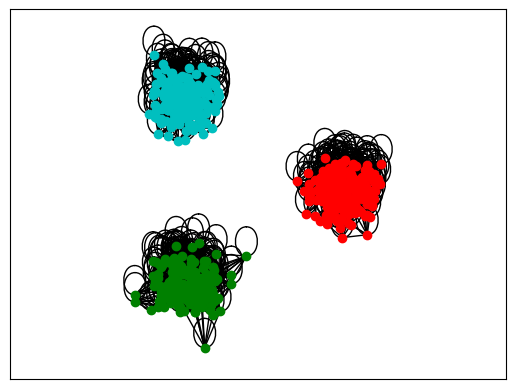

In [ ]:
from utils import plot_edges_and_points

num_samples = 600
n_blobs = 3
k = 10

X, Y = blobs(num_samples=num_samples,n_blobs=n_blobs)
W = build_similarity_graph(X, k=k)
laplacian = build_laplacian(W, laplacian_normalization='sym')
chosen_eig_indices = list(range(0, n_blobs))
Y_rec = spectral_clustering(laplacian, chosen_eig_indices=chosen_eig_indices, num_classes=3)

plot_edges_and_points(X, Y_rec,W)


### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

When chosen_eig_indices is None, we automatically select the eigenvectors associated with the smallest non-zero eigenvalues.
The first eigenvector is ignored because it is constant and does not contain clustering information.
We then take the next k eigenvectors, where k is the desired number of clusters.

This works because these eigenvectors capture the main low-frequency structure of the graph, which corresponds to the clusters.

For small variance, the blobs are well separated and spectral clustering correctly recovers the 4 clusters.
As the variance increases, the blobs start to overlap and the similarity graph becomes less structured.
Edges between different blobs appear, making clusters harder to separate.
As a result, spectral clustering gradually degrades and eventually fails to recover the correct clusters when the variance is too large.


In [252]:
num_samples = 600
n_blobs = 4
eps = 0.6
blob_vars = [0.15, 0.23, 0.45, 0.6, 0.7, 0.8] 
cmap = plt.cm.get_cmap("tab10", n_blobs)

/var/folders/bg/rn6v3_d90s7b47lrzgg2ds0c0000gn/T/ipykernel_2353/2570595287.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", n_blobs)


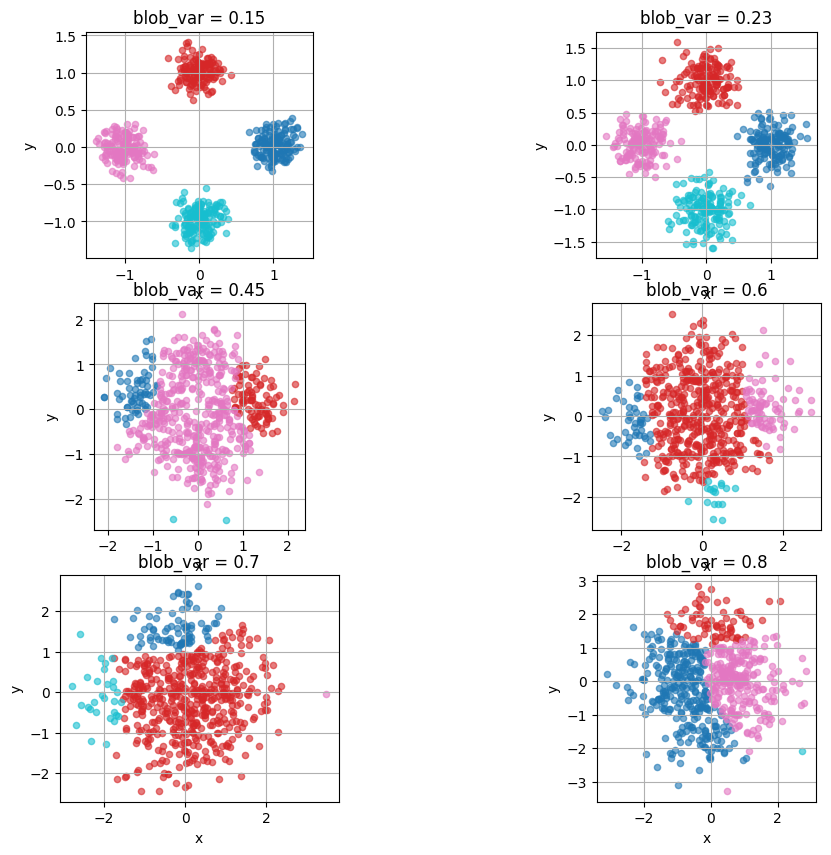

In [267]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]

for i, blob_var in enumerate(blob_vars):
    X, Y = blobs(num_samples=num_samples, n_blobs=n_blobs, blob_var=blob_var)
    W = build_similarity_graph(X, eps=eps)
    L = build_laplacian(W, laplacian_normalization="rw")
    Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=n_blobs)

    ax = axs[i]
    for k in range(n_blobs):
        ax.scatter(
            X[Y_rec == k, 0],
            X[Y_rec == k, 1],
            s=20,
            color=cmap(k),
            alpha=0.6
        )

    ax.set_title(f"blob_var = {blob_var}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    ax.grid(True)




### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

I used both thresholding and k-means to build the cluster assignments.

I think thresholding is better to use when there are 2 well-separated clusters and the eigenvectors clearly split the data. In these situations, thresholding is easy to apply and works well.

I think K-means is the best to use in more general cases, especially when there are more than two clusters or when the clusters overlap. It is more robust and adapts better to complex cluster shapes in the eigenvector space.


### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

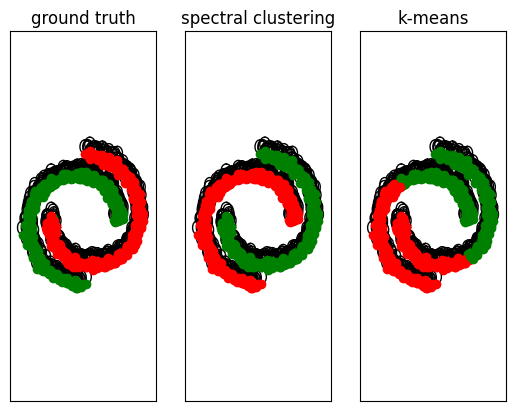

In [280]:
num_samples = 600
n_class = 2
chosen_eig_indices = None
k = 8

X, Y = two_moons(num_samples=num_samples)
W = build_similarity_graph(X, k=k)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, num_classes=n_class, chosen_eig_indices=chosen_eig_indices)
kmeans = KMeans(n_clusters=n_class, n_init="auto").fit_predict(X)

plot_clustering_result(X, Y, L, Y_rec, kmeans)

We observe a clear difference between spectral clustering and k-means on the two_moons dataset.

Spectral clustering correctly separates the two moons because it uses a graph structure that follows the shape of the data.

K-means fails because it assumes clusters with simple convex shapes, which is not the case here.

To sum up, spectral clustering handles non-linear structures well, while k-means works better for simple linear clusters.


### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

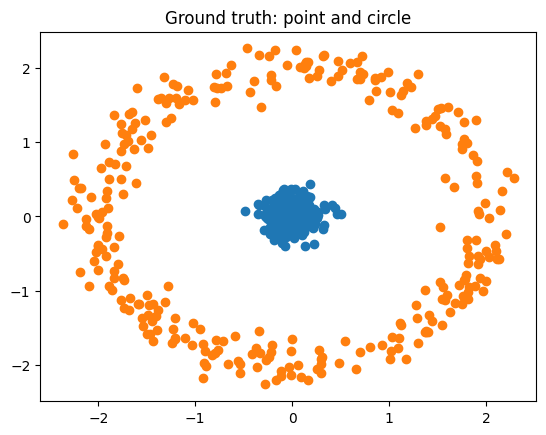

In [282]:
num_samples = 600

X, Y = point_and_circle(num_samples=num_samples)
plot_clusters(X, Y)
plt.title("Ground truth: point and circle")
plt.show()



using uniform laplacian


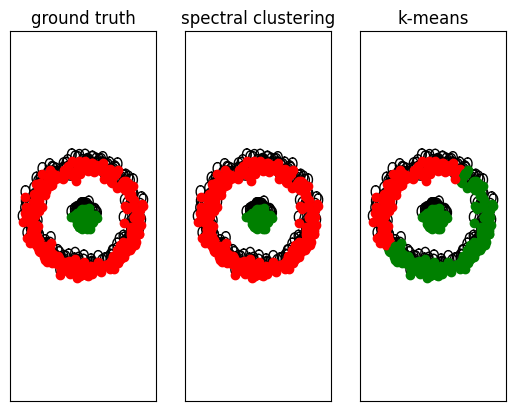

In [285]:
print("using uniform laplacian")
k = 10
eps = 0.3
W = build_similarity_graph(X, k=k, eps=eps)
laplacian = build_laplacian(W)
Y_unn = spectral_clustering(
    laplacian,
    chosen_eig_indices=[1],
    num_classes=2
)

kmeans = KMeans(n_clusters=2, n_init="auto").fit_predict(X)

plot_clustering_result(X, Y, laplacian, Y_unn, kmeans)

using random-walk Laplacian


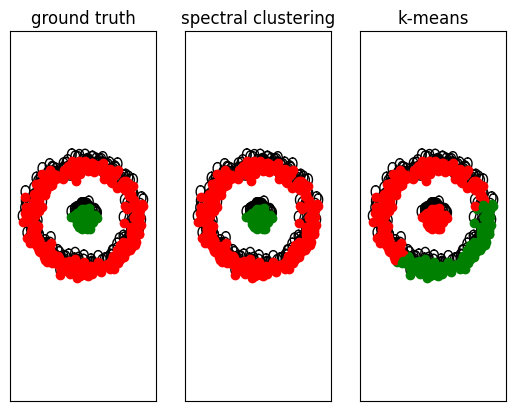

In [ ]:
print("using random-walk Laplacian")
k = 10
eps = 0.3
W = build_similarity_graph(X, k=k, eps=eps)
laplacian = build_laplacian(W, laplacian_normalization='rw')
Y_non_unn = spectral_clustering(
    laplacian,
    chosen_eig_indices=[1],
    num_classes=2
)

kmeans = KMeans(n_clusters=2, n_init="auto").fit_predict(X)

plot_clustering_result(X, Y, laplacian, Y_non_unn, kmeans)

Spectral clustering correctly separates the center points from the circle.
This is true for both the normal Laplacian and the random-walk Laplacian.

The graph connects mainly points from the same structure.
So spectral clustering follows the graph structure and finds the two clusters.

K-means fails because it uses straight boundaries. It cannot separate one cluster that is inside another.


### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

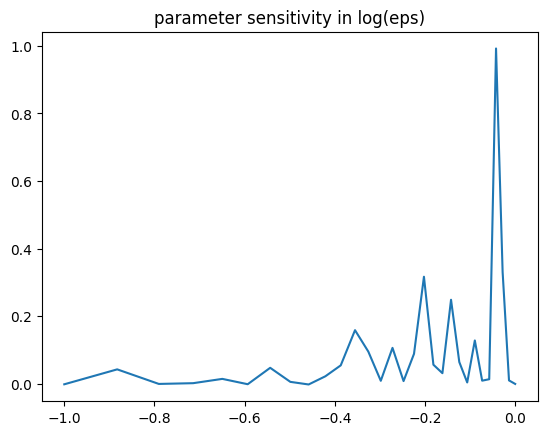

In [287]:
parameter_sensitivity("eps")

When varying $\epsilon$:
For very small $\epsilon$, the graph is poorly connected, so spectral clustering is unstable and the result is bad.
For intermediate $\epsilon$ values, the graph correctly reflects the data structure and the clustering is stable.
For very large $\epsilon$, the graph becomes almost fully connected and the clustering quality decreases again.
So spectral clustering is sensitive to $\epsilon$ and only works well in a limited range.


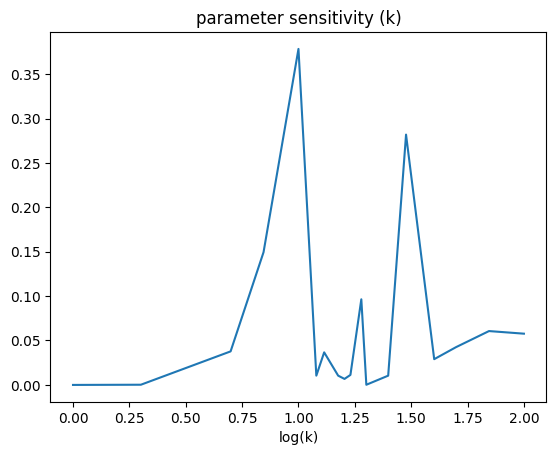

In [145]:
parameter_sensitivity("k")

When varying k:
For very small k, the graph is too sparse and may become disconnected, which leads to unstable results.
For intermediate k values, the graph is well connected and the clustering is stable.
For very large k, the graph becomes too dense and clusters are mixed, reducing performance.
Overall, spectral clustering is more stable for k than for $\epsilon$, but extreme values still degrade the result.

Last thing : we observe that spectral clustering is stable for a wider range of k values than $\epsilon$ values.


### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

If true labels are not available, we cannot use supervised measures such as accuracy or the Adjusted Rand Index, because they require ground truth.
Instead, we can rely on graph-based clustering metrics such as coverage, internal density, modularity, and conductance.
These metrics evaluate the quality of the clustering using only the graph structure.


### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

Image segmentation with epsilon : eps = 0.10


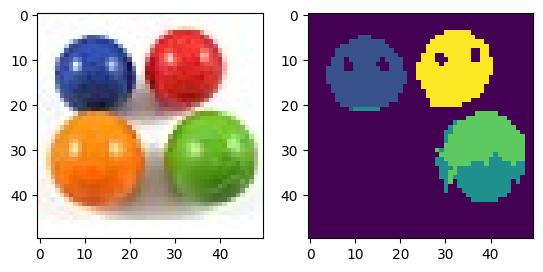

Image segmentation with epsilon : eps = 0.20


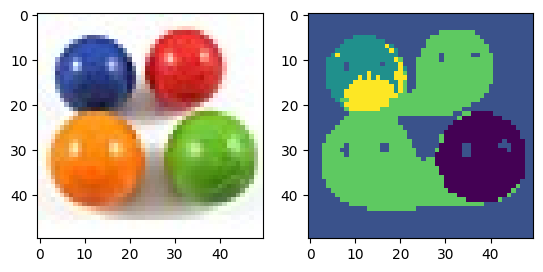

Image segmentation with epsilon : eps = 0.30


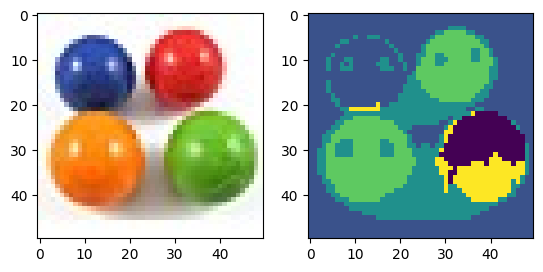

Image segmentation with epsilon : eps = 0.40


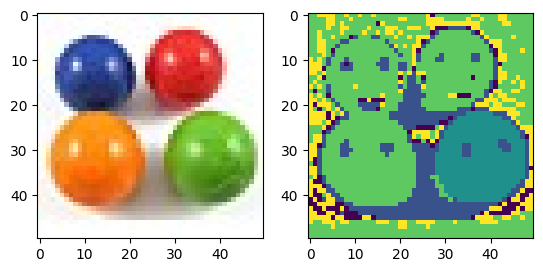

Image segmentation with epsilon : eps = 0.50


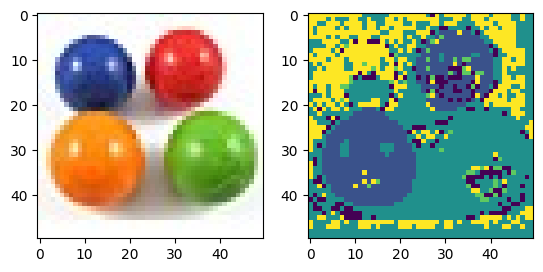

Image segmentation with epsilon : eps = 0.60


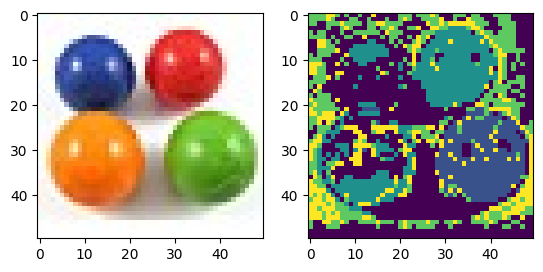

Image segmentation with epsilon : eps = 0.70


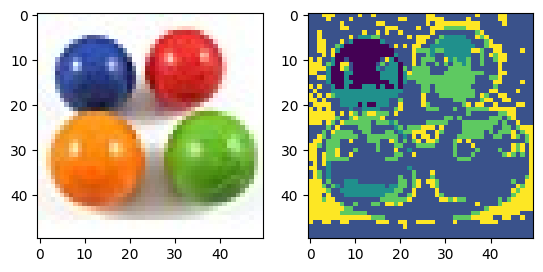

Image segmentation with epsilon : eps = 0.80


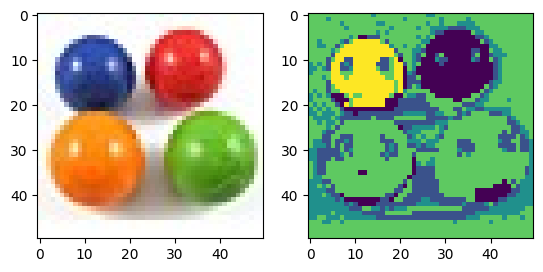

Image segmentation with epsilon : eps = 0.90


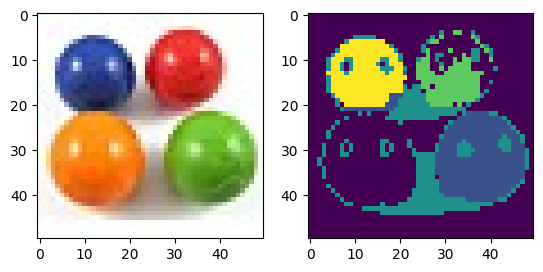

Image segmentation with epsilon : eps = 1.00


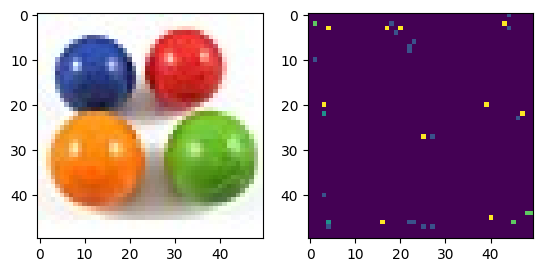

In [165]:
eps = np.linspace(0.1, 1, 10)
for e in eps:
    print(f"Image segmentation with epsilon : eps = {e:.2f}")
    image_segmentation(
        input_img='four_elements.bmp',
        eps=e, var=1, k=0, 
        ln='rw', 
        n_class=5, chosen_eig_indices=None
    )

Image segmentation with epsilon : eps = 0.10


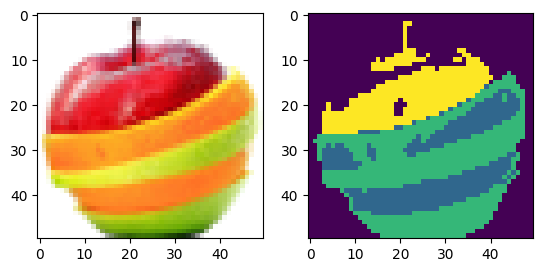

Image segmentation with epsilon : eps = 0.20


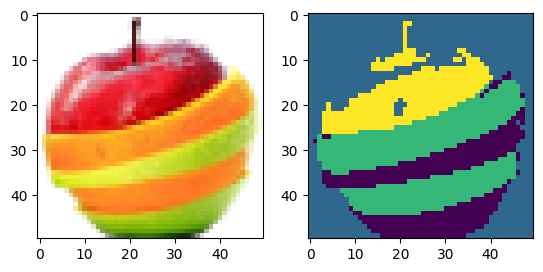

Image segmentation with epsilon : eps = 0.30


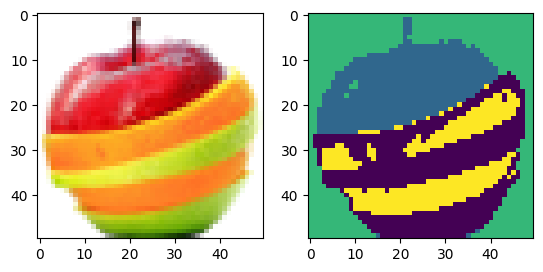

Image segmentation with epsilon : eps = 0.40


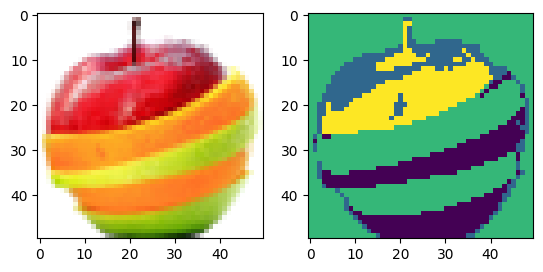

Image segmentation with epsilon : eps = 0.50


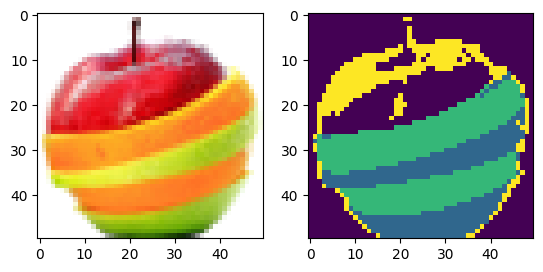

Image segmentation with epsilon : eps = 0.60


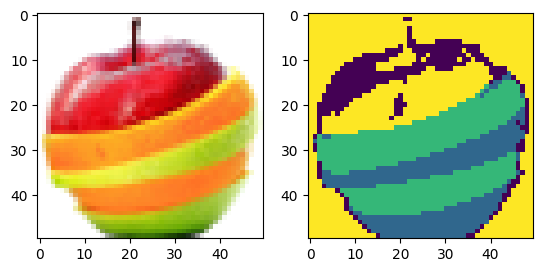

Image segmentation with epsilon : eps = 0.70


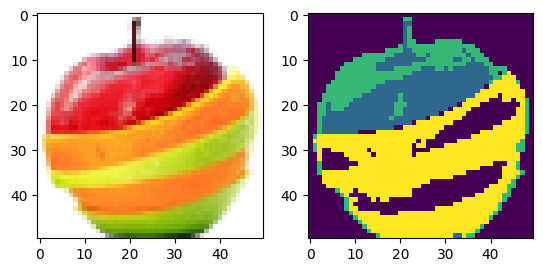

Image segmentation with epsilon : eps = 0.80


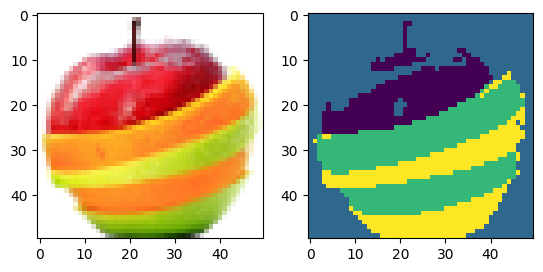

Image segmentation with epsilon : eps = 0.90


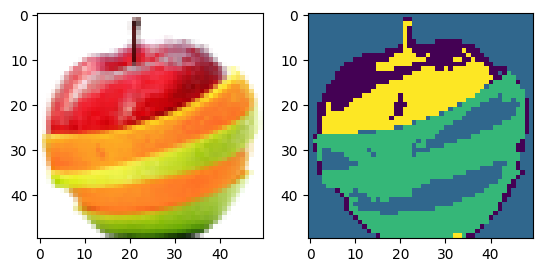

Image segmentation with epsilon : eps = 1.00


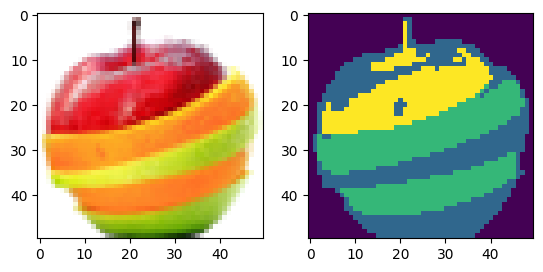

In [172]:
eps = np.linspace(0.1, 1, 10)
for e in eps:
    print(f"Image segmentation with epsilon : eps = {e:.2f}")
    image_segmentation(
        input_img='fruit_salad.bmp',
        eps=e, var=1.3, k=65, 
        ln='rw', 
        n_class=4, chosen_eig_indices=[1,2,3,4,5]
    )

We used different parameters for the two images.

For the four_elements image:

- We chose 5 classes, corresponding to the 4 colored elements and the background. We initially tried 6 classes (4 elements + background + shadows) but the results were worse and less stable.
- We used an $\epsilon$ graph and vary $\epsilon$ from 0.1 to 1.0 using 10 values to study its influence.
- We set the variance parameter to 1 for the similarity function.
- We used the random-walk Laplacian, which gives more stable results.
- Spectral clustering is then applied to obtain the segmentation.


For the fruit_salad image:
- We chose 4 classes, corresponding to the main parts of the fruit visible in the image 
- We used a kNN graph with k = 65 to ensure good connectivity between pixels.
- We set the variance parameter to 1.3 to better account for color variations in the image.
- We also vary $\epsilon$ from 0.1 to 1.0 using 10 values, although the kNN graph makes the method less sensitive to $\epsilon$.
- We use the random-walk Laplacian for better stability.
- Spectral clustering is applied using the eigenvectors with indices [1, 2, 3, 4, 5].


Two failures (one for each image are shown below). Parameters are printed : 


Failure epsilon : eps = 0.95


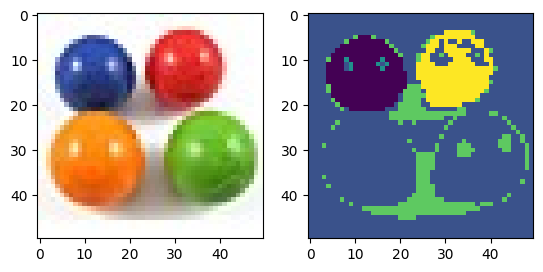

In [289]:
eps = 0.95
print(f"Failure epsilon : eps = {eps:.2f}")
image_segmentation(
    input_img='four_elements.bmp',
    eps=eps, var=1, k=0, 
    ln='rw', 
    n_class=5, chosen_eig_indices=None
)

Failure epsilon: eps = 0.20


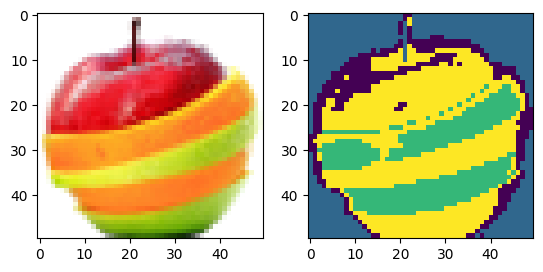

In [293]:
e = 0.2
print(f"Failure epsilon: eps = {e:.2f}")
image_segmentation(
    input_img='fruit_salad.bmp',
    eps=e, var=1.3, k=5, 
    ln='rw', 
    n_class=4, chosen_eig_indices=[1,2,3,4,5]
)

### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

Two simple techniques can reduce the computational and memory cost of spectral clustering.

- First, we can reduce the number of nodes by grouping pixels together, for example by using patches or superpixels instead of individual pixels. This drastically reduces the size of the graph.

- Second, we can avoid building a full graph by using a sparse graph, such as a kNN graph or an $\epsilon$-graph. This reduces both memory usage and computation time since each node is connected to only a few neighbors.


### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 

Here, we choose a larger image (lion.jpg) and apply spectral clustering with scalability modifications.

Main idea:
- A full pixel graph is too large, so we reduce the number of nodes and keep the graph sparse.

Pipeline and design choices:
- Patch representation (patch_size = 20):
  - We replace pixels by non overlapping 20x20 patches.
  - Each patch becomes one node, which reduces the number of nodes by a large factor.
- Features for each patch:
  - Mean RGB color of the patch.
  - Mean Sobel gradient magnitude (scaled by 3 to capture texture and edges.
  - We then standardize features so that color, gradient and coordinates have comparable influence.
- Landmarks (n_landmarks = 200):
  - We run KMeans on patch features and keep only the cluster centers.
  - Spectral clustering is performed only on these landmarks, which makes the eigenvalue computation much cheaper.
  - Labels are then assigned to all patches by nearest-landmark projection.
- Graph construction:
  - We use a kNN graph with k=8 to keep the similarity matrix sparse.
  - We use the random-walk Laplacian for stability.
- Post-processing:
  - A small median filter (size = 3) is applied on the label image to remove isolated noisy patches.

Results:
- The segmentation produces large coherent regions separating the lion from the background. However, I tried a lot of configurations, none of them gave me an image very well segmented. Results are very sensitive to the size of patches and to the number of classes. 
For the classes, I first chose 2 classes, but it seems that it's better to split the lion in two parts : it's head and it's body. That's why I chose 3 classes. 


Failure mode:
- If the number of patches is still too large (smaller patch_size), the graph and eigen-decomposition become slow again.
- If patch_size is too large, the segmentation becomes blocky and loses boundaries.
- If k is too small, the graph may become poorly connected and the result becomes unstable.

Overall, the results remain rather poor compared to what we would expect from a dedicated image segmentation method, mainly because spectral clustering is very sensitive to the graph construction and to the chosen features.


Original image shape: (636, 960, 3)


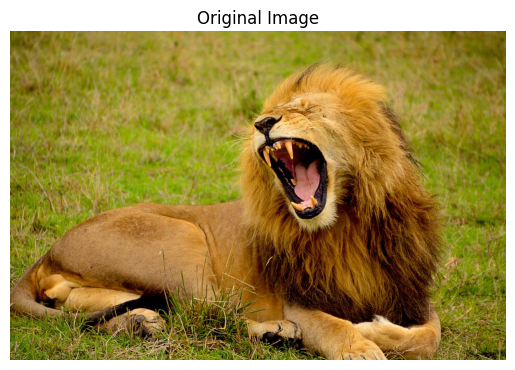

In [294]:
filename = "data/lion.jpg"
img = io.imread(filename)
img = (img - img.min()) / (img.max() - img.min())

h, w, c = img.shape
print("Original image shape:", img.shape)

plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()

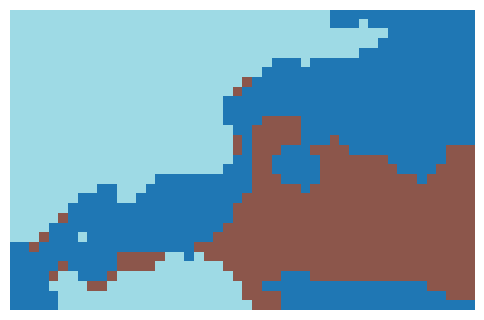

In [397]:
from skimage.filters import sobel
from scipy.ndimage import median_filter

def extract_patches_features(img, patch_size=20):
    h, w, c = img.shape
    h_new = h // patch_size
    w_new = w // patch_size

    gray = np.mean(img, axis=2)
    grad = sobel(gray)

    X_feat = []

    for i in range(h_new):
        for j in range(w_new):
            patch = img[
                i*patch_size:(i+1)*patch_size,
                j*patch_size:(j+1)*patch_size
            ]
            patch_grad = grad[
                i*patch_size:(i+1)*patch_size,
                j*patch_size:(j+1)*patch_size
            ]

            mean_color = patch.mean(axis=(0, 1))
            mean_grad = 3.0 * patch_grad.mean()   
            coord = np.array([i / h_new, j / w_new])

            X_feat.append(
                np.concatenate([mean_color, [mean_grad], coord])
            )

    return np.array(X_feat), h_new, w_new


patch_size = 20
num_classes = 3
k = 8
n_landmarks = 200

img = io.imread("data/lion.jpg")
img = (img - img.min()) / (img.max() - img.min())

X_feat, h_new, w_new = extract_patches_features(img, patch_size)
X_feat = (X_feat - X_feat.mean(axis=0)) / (X_feat.std(axis=0) + 1e-8)

kmeans = KMeans(n_clusters=n_landmarks, n_init="auto")
X_landmarks = kmeans.fit(X_feat).cluster_centers_

W = build_similarity_graph(X_landmarks, var=1.0, k=k)
L = build_laplacian(W, laplacian_normalization="rw")
Y_landmarks = spectral_clustering(L, num_classes=num_classes)

D = pairwise_distances(X_feat, X_landmarks)
nearest = np.argmin(D, axis=1)
Y_full = Y_landmarks[nearest]

Y_img = Y_full.reshape(h_new, w_new)

Y_img = median_filter(Y_img, size=3)


plt.figure(figsize=(6, 6))
plt.imshow(Y_img, cmap="tab20")
plt.axis("off")
plt.show()
